In [66]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
from xgboost.sklearn import XGBClassifier  #Additional scklearn functions
from sklearn.model_selection import cross_validate, GridSearchCV

In [68]:
%%time
version='v_6_2019-04-23v9'
workdir=os.getcwd()+'/'+version
os.chdir(workdir)
os.makedirs('fig', exist_ok=True)
fig_dir=workdir+'/fig'
algo_name_old=['F8T2D3D', 'F8Sth0', 'F8Sth10', 'F8Sth20', 'F8Sdr25', 'F8Sdr50', 'F8Sdr100', 'F8Tth0', 'F8Tth10', 'F8Tth20', 'F8Tdr25', 'F8Tdr50', 'F8Tdr100']
algo_name=['T2D3D', 'STCth0', 'STCth10', 'STCth20', 'STCdr25', 'STCdr50', 'STCdr100', 'Tth0', 'Tth10', 'Tth20', 'Tdr25', 'Tdr50', 'Tdr100']
algo={}
for i in range(len(algo_name)):
    algo[i]=pd.read_csv(workdir+'/data/{}.csv'.format(algo_name_old[i]))

FileNotFoundError: [Errno 2] No such file or directory: '/grid_mnt/vol__vol_U__u/llr/cms/hakimi/stage_llr/stagellr/200PU/v_6_2019-04-23v9/v_6_2019-04-23v9'

In [50]:
%%time
#cut
ptcut=10
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]
    algo_cut[i].dropna(inplace=True)
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

CPU times: user 1.46 s, sys: 228 ms, total: 1.69 s
Wall time: 1.69 s


In [51]:
from sklearn.model_selection import train_test_split
columns=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean','genpart_pt']


X_train={}
X_test={}
y_train={}
y_test={}

for i in algo:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(algo_cut[i][columns], algo_cut[i]['genpart_pid'], test_size=0.2)

In [52]:
X_pt={}
for i in algo:
    X_pt[i]=X_test[i]['genpart_pt']
    X_test[i]=X_test[i].drop(columns='genpart_pt')
    X_train[i]=X_train[i].drop(columns='genpart_pt')
    
columns.remove('genpart_pt')


In [53]:
train={}
test={}

for i in algo:
    train[i] = xgb.DMatrix(data=X_train[i],label=y_train[i], feature_names=columns)
    test[i] = xgb.DMatrix(data=X_test[i],label=y_test[i],feature_names=columns)

In [54]:
%%time
for i in algo:        
    algo_cut[i]['algo']=algo_name[i]
    algo_cut[i]['electron']=(algo_cut[i]['genpart_pid']==0)
    if i==0:
        algo_all=algo_cut[i]
    else:
        algo_all=pd.concat([algo_all,algo_cut[i]])


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


CPU times: user 2.04 s, sys: 2.51 s, total: 4.55 s
Wall time: 4.56 s


In [69]:
os.makedirs(fig_dir+'/importance', exist_ok=True)
def modelfit(booster, X_train, X_test, y_train, y_test, features, useTrainCV=True, cv_folds=5, early_stopping_rounds=30):
    
    if useTrainCV:
        xgb_param = booster.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train[features], label=y_train)
        xgtest = xgb.DMatrix(X_test[features], label=y_test)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=booster.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        booster.set_params(n_estimators=cvresult.shape[0])
        print("CV results: n_estimators={}".format(cvresult.shape[0]))
    
    #Fit the algorithm on the data
    booster.fit(X_train[features], y_train, eval_metric='auc')
        
    #Predict training set:
    train_pred = booster.predict(X_train[features])
    fpr, tpr, threshold = metrics.roc_curve(y_train,train_pred)
    roc_auc = metrics.auc(fpr, tpr)
    #Print model report:
    print ("\nModel Report")
    
    print ("Accuracy : {:.4%}".format( metrics.accuracy_score(y_train.values, train_pred)))
    print ("AUC Score (Train): {:4%}".format(roc_auc))
    
    #  Predict on testing data:
    test_pred = booster.predict(X_test[features])
    fpr, tpr, threshold = metrics.roc_curve(y_test,test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print ("AUC Score (Test): {:4%}".format(roc_auc))
    
    plt.figure(figsize=(20,5))
    ax=plt.subplot(111)
    xgb.plot_importance(booster,ax,grid=False, title=algo_name[i], importance_type='gain');
    plt.savefig(fig_dir+'/importance/{}.png'.format(algo_name[i]))
                
    
    return test_pred

CV results: n_estimators=62

Model Report
Accuracy : 97.5266%
AUC Score (Train): 96.936461%
AUC Score (Test): 96.440201%
CPU times: user 2min 42s, sys: 1.12 s, total: 2min 43s
Wall time: 5.88 s


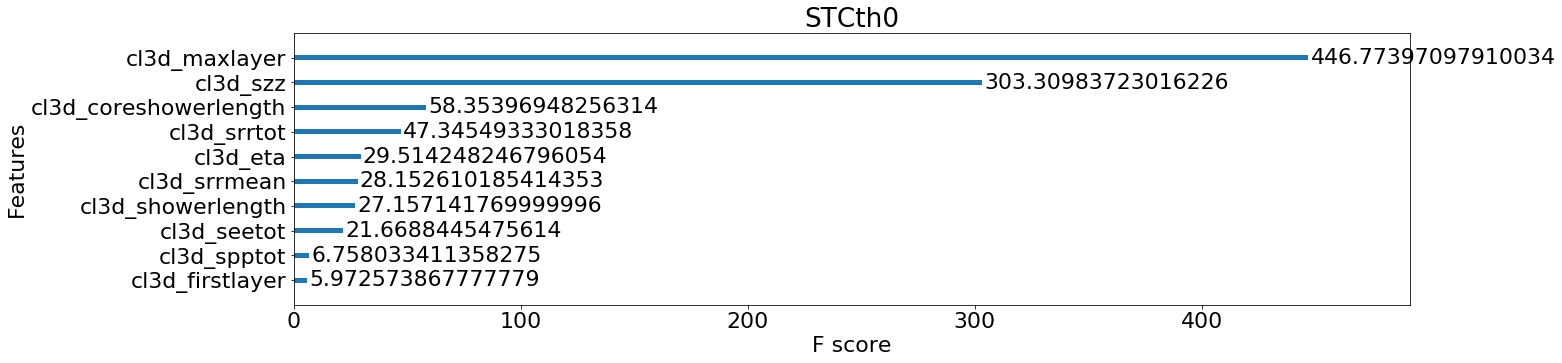

In [70]:
%%time
i=1 #choose the algo on which to run 
features=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']
xgb1 = XGBClassifier(
        learning_rate =0.2,
        n_estimators=500,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=30,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, X_train[i], X_test[i], y_train[i], y_test[i], features)

In [57]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    
    'max_depth':[3,4,5]
    
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.2, n_estimators=81, max_depth=5,
                                        min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=10, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[i],y_train[i])
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 4} 0.9923038526221417
CPU times: user 9.52 s, sys: 257 ms, total: 9.78 s
Wall time: 7.81 s


CV results: n_estimators=81

Model Report
Accuracy : 98.2863%
AUC Score (Train): 97.838840%
AUC Score (Test): 97.479810%
CV results: n_estimators=81

Model Report
Accuracy : 97.6201%
AUC Score (Train): 97.052152%
AUC Score (Test): 96.416640%
CV results: n_estimators=51

Model Report
Accuracy : 97.4027%
AUC Score (Train): 96.763965%
AUC Score (Test): 96.644594%
CV results: n_estimators=51

Model Report
Accuracy : 97.2888%
AUC Score (Train): 96.641476%
AUC Score (Test): 95.948289%
CV results: n_estimators=51

Model Report
Accuracy : 97.4275%
AUC Score (Train): 96.803580%
AUC Score (Test): 96.298906%
CV results: n_estimators=51

Model Report
Accuracy : 97.3944%
AUC Score (Train): 96.782161%
AUC Score (Test): 96.325636%
CV results: n_estimators=51

Model Report
Accuracy : 97.4580%
AUC Score (Train): 96.851697%
AUC Score (Test): 96.164046%
CV results: n_estimators=51

Model Report
Accuracy : 97.8196%
AUC Score (Train): 97.294189%
AUC Score (Test): 96.869500%
CV results: n_estimators=51

Mod

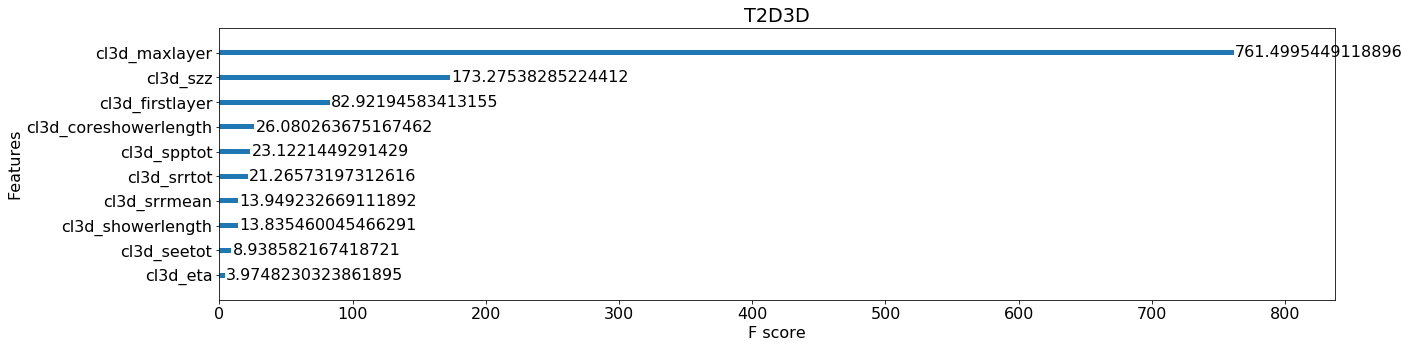

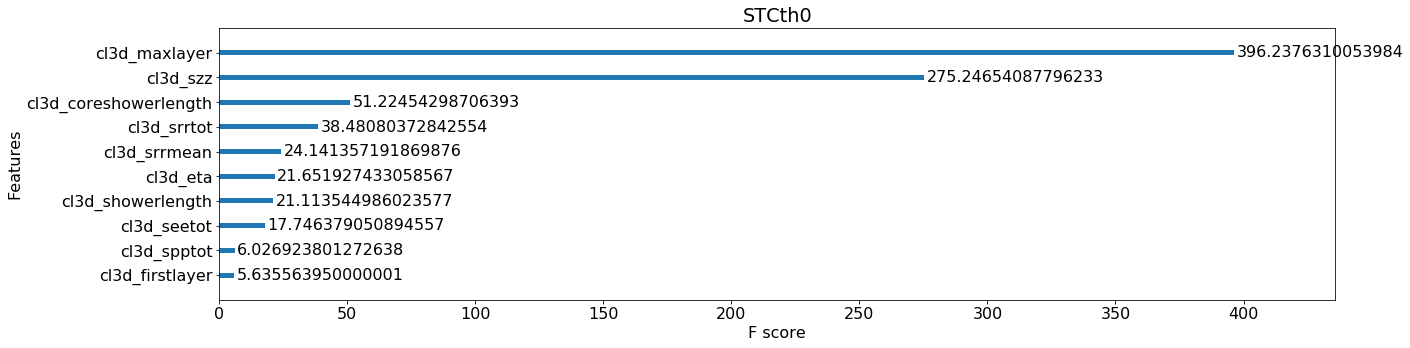

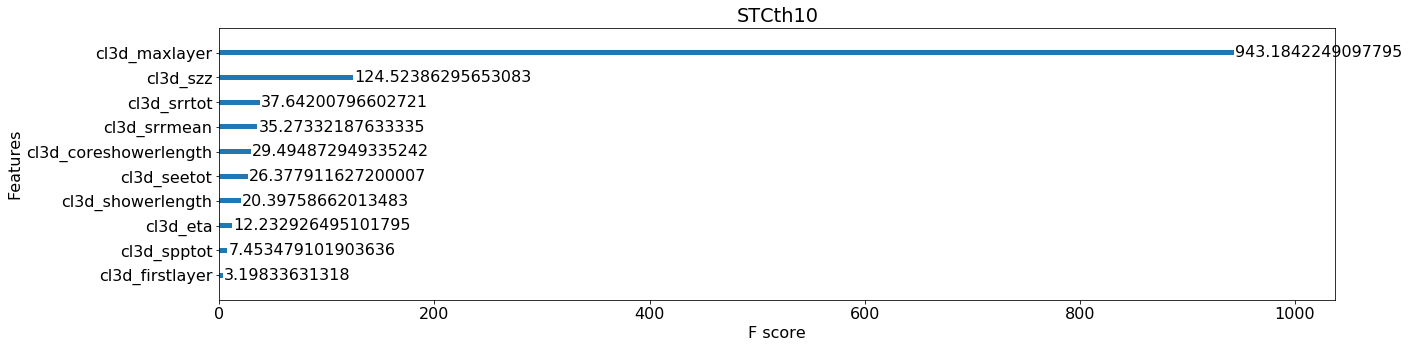

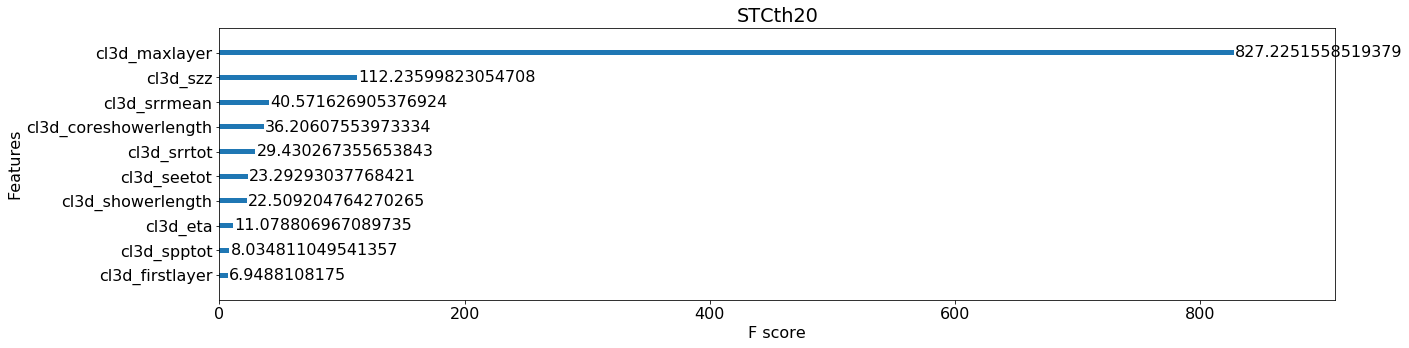

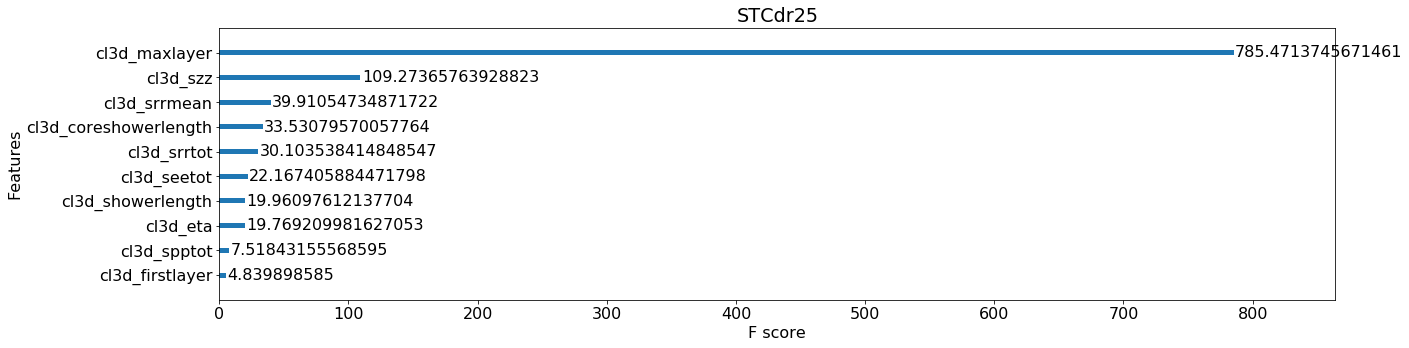

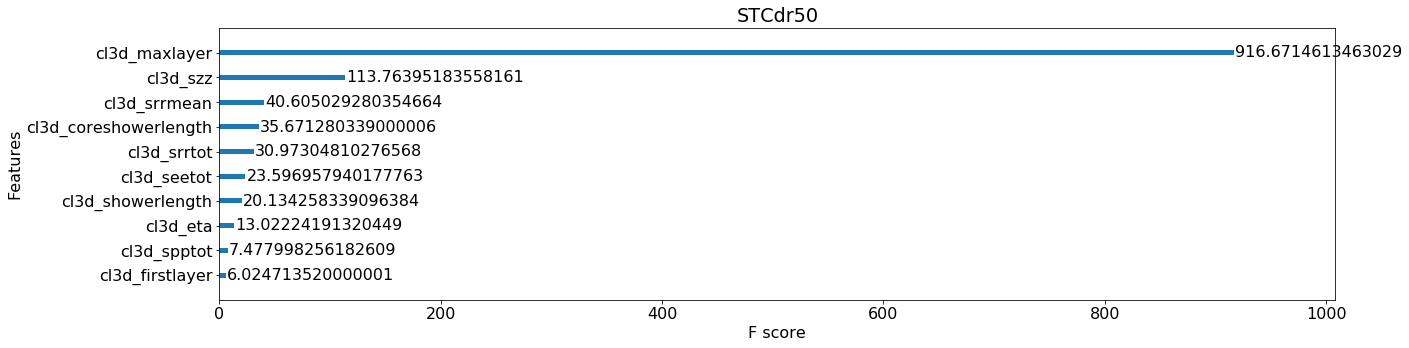

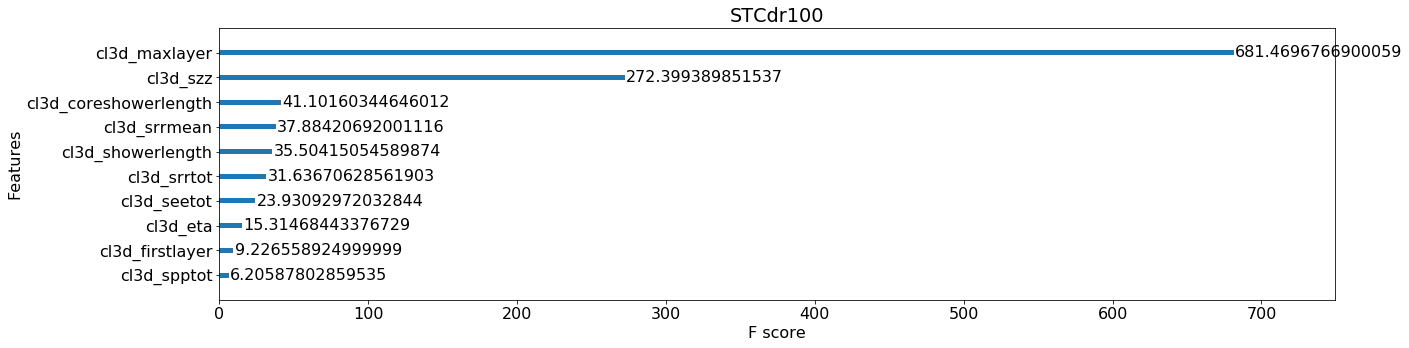

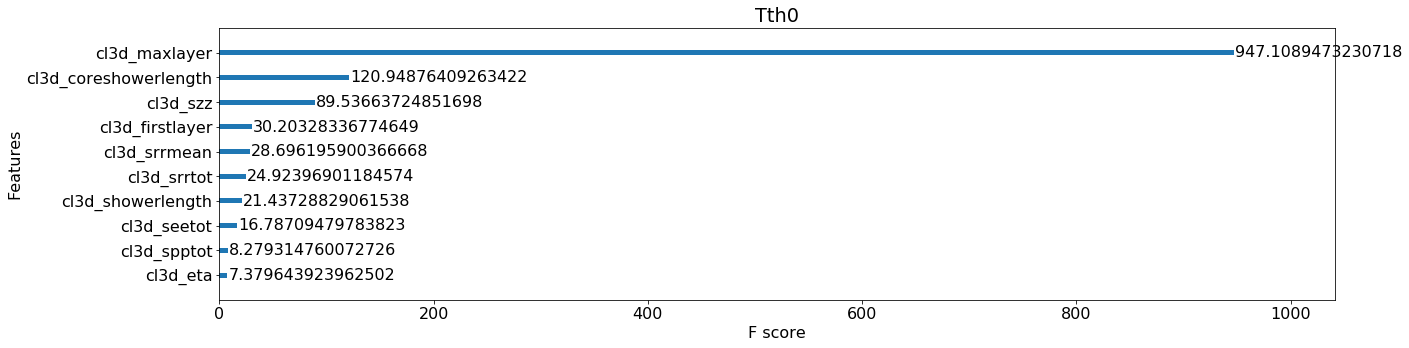

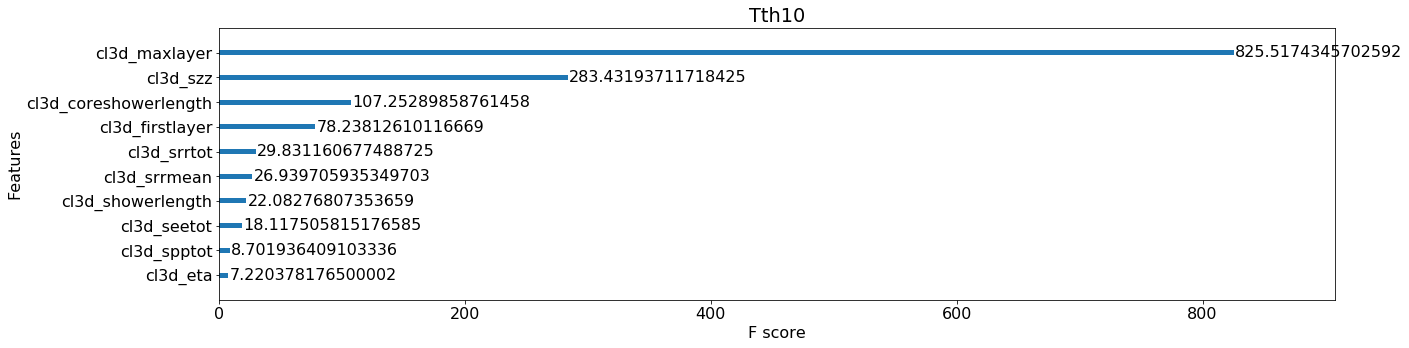

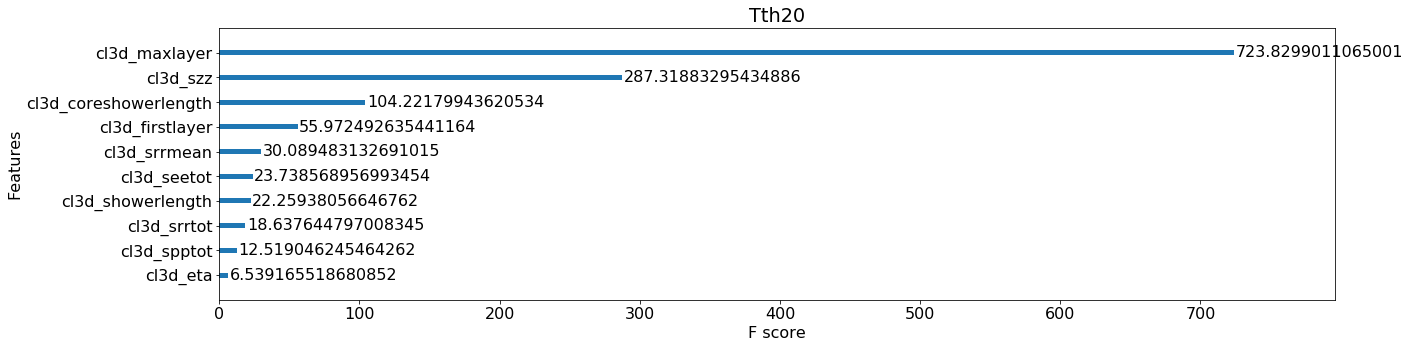

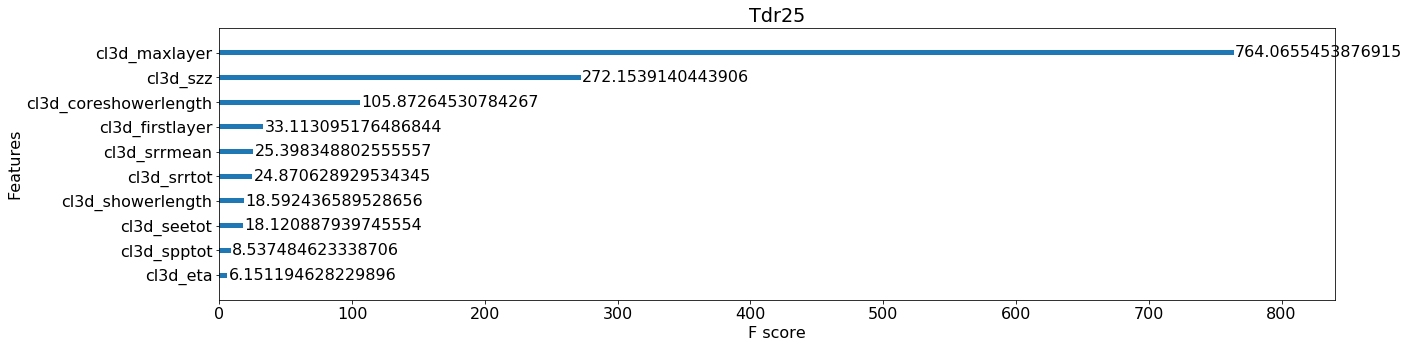

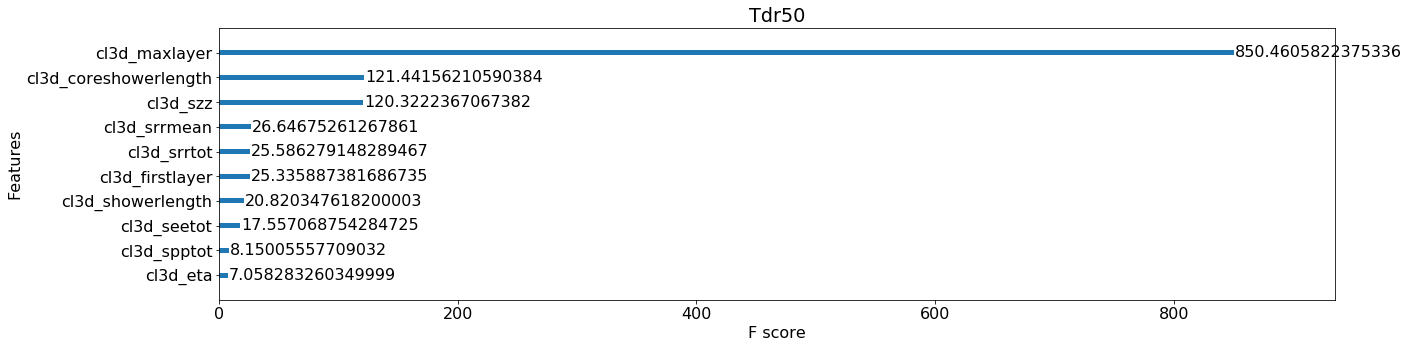

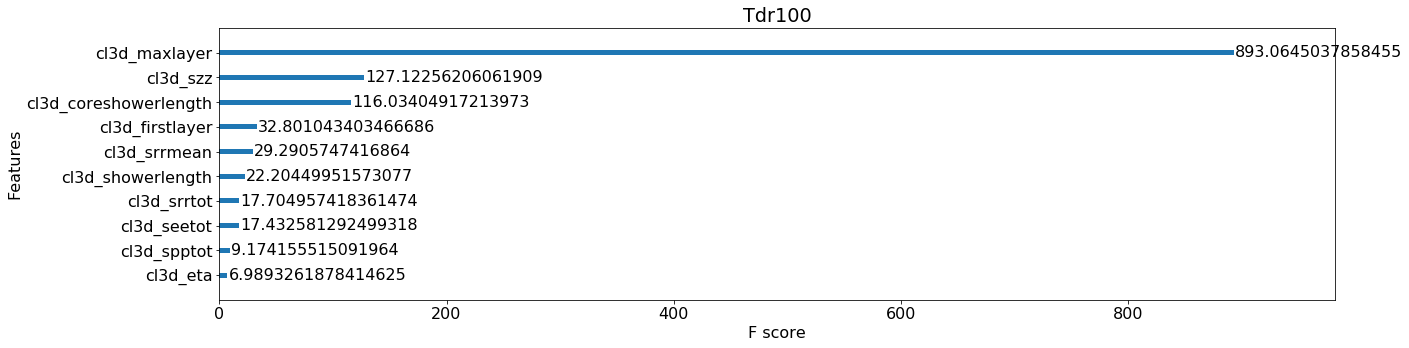

In [64]:
features=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']
predictions={}
os.makedirs(fig_dir+'/importance', exist_ok=True)
matplotlib.rcParams.update({'font.size': 16})
for i in algo:
        predictions[i]=modelfit(xgb1,X_train[i], X_test[i], y_train[i], y_test[i], features)

### Evaluate BDT fluctuation by training  times for one algo and plotting AUC

### training on different data set


In [ ]:
"""%%time
booster_test={}
pred_test={}
n_train=20
j=1 #training on algo 1: STCth0
plt.figure(figsize=(10,4))
X_train_test={}
X_test_test={}
y_train_test={}
y_test_test={}
test_test={}
train_test={}
auc_score=[]
depth=[4,6,8,10]
for step in depth:
    param[2]=('max_depth',step)
    for i in range(n_train):
        
        X_train_test[i], X_test_test[i], y_train_test[i], y_test_test[i] = train_test_split(algo_cut[j][columns], algo_cut[j]['genpart_pid'], test_size=0.25)
        train_test[i] = xgb.DMatrix(data=X_train_test[i],label=y_train_test[i], feature_names=columns)
        test_test[i] = xgb.DMatrix(data=X_test_test[i],label=y_test_test[i],feature_names=columns)
        booster_test[i]=xgb.train(param,train_test[i],num_boost_round=num_trees)
        pred_test[i]=booster_test[i].predict(test_test[i])
        fpr, tpr, threshold = metrics.roc_curve(y_test_test[i],pred_test[i])
        roc_auc = metrics.auc(fpr, tpr)
        #plt.scatter(i, roc_auc, c='blue')
        auc_score.append(roc_auc)
    print('for num_trees={}, AUC mean={:.4%}, std={:.5%}'.format(num_trees,np.mean(auc_score), np.std(auc_score)))"""

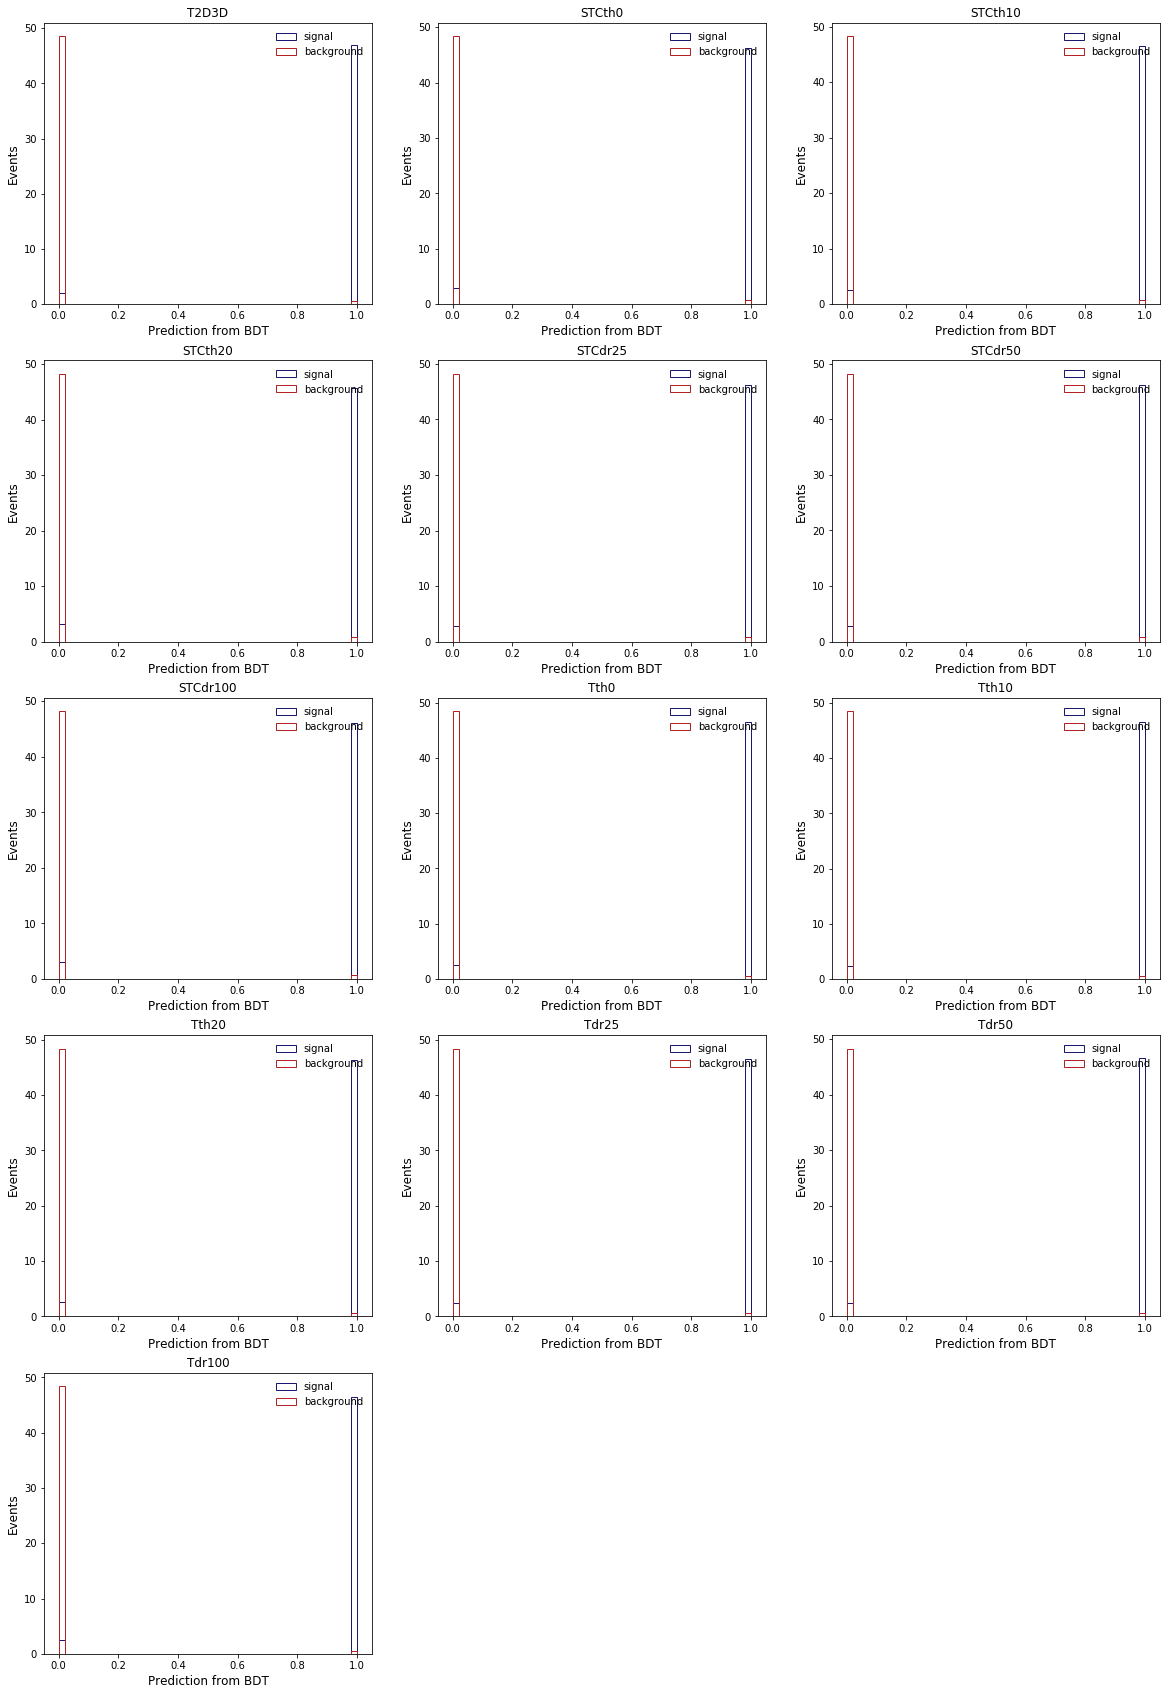

In [59]:
plt.figure(figsize=(20,30));
for i in algo:
# plot all predictions (both signal and background)
    
    plt.subplot(5,3,i+1)
# plot signal and background separately
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal', density=True);
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);
plt.savefig(fig_dir+'/predictions.png')

NameError: name 'booster' is not defined

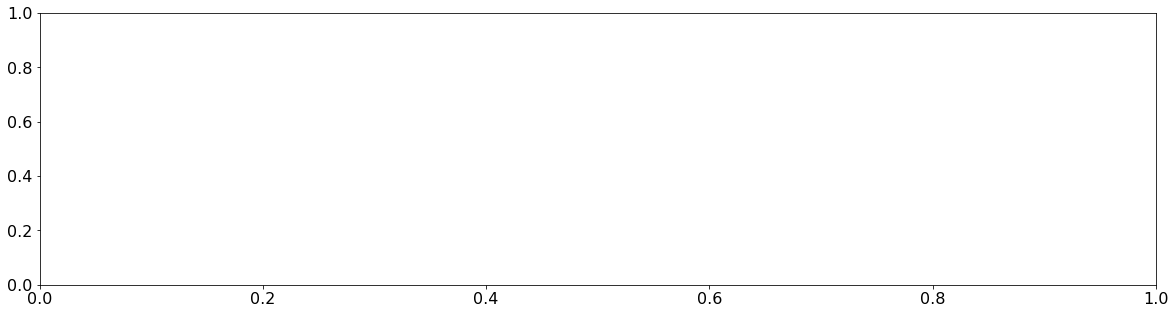

In [60]:
"""#plot importance of features for each algo
os.makedirs(fig_dir+'/importance', exist_ok=True)
matplotlib.rcParams.update({'font.size': 16})
for i in algo:
    plt.figure(figsize=(20,5))
    ax=plt.subplot(111)
    xgb.plot_importance(booster[i],ax,grid=False, title=algo_name[i], importance_type='gain');
    plt.savefig(fig_dir+'/importance/{}.png'.format(algo_name[i]))"""

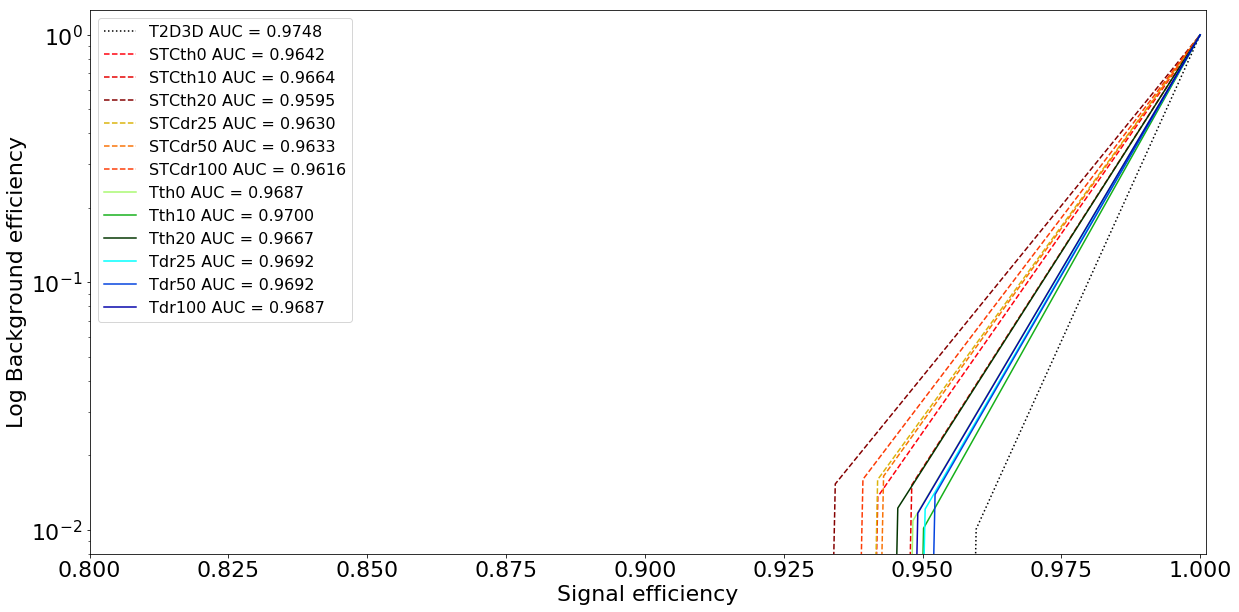

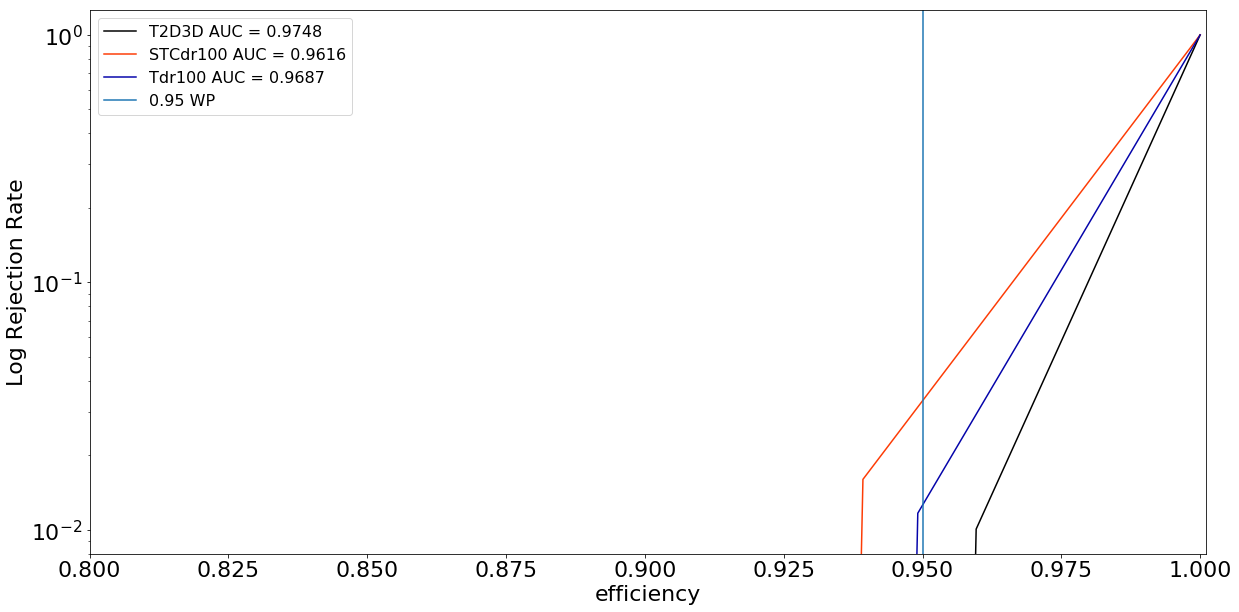

In [65]:
#build ROC
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for i in algo:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr, label ='%s AUC = %0.4f' %(algo_name[i],roc_auc), c=color[i], linestyle=style[i])
plt.legend(loc = 'upper left', fontsize=16)
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.8,1.001)
plt.yscale('log')
    #plt.ylim(0.6,1.05)
plt.xlabel('Signal efficiency')
plt.ylabel('Log Background efficiency') 
plt.savefig(fig_dir+'/ROC.png')

plt.figure(figsize=(20,10))
for i in [0,6,12]:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr, label ='%s AUC = %0.4f' %(algo_name[i],roc_auc), c=color[i], linestyle='-')
plt.axvline(x=0.950, label='0.95 WP')
plt.legend(loc = 'upper left', fontsize=16)
plt.xlim(0.8,1.001)
plt.yscale('log')
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate') 
plt.savefig(fig_dir+'/ROC_example.png')

In [ ]:
def score(ytest, ypred, thr):
    fpr, tpr, threshold = metrics.roc_curve(ytest,ypred)
    roc=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    roc_cut=roc[roc['tpr']>thr];
    score=np.min(roc_cut['fpr']);
    return score

In [ ]:
thr=0.995
scor=[]
for i in algo:
    scor.append(score(y_test[i], predictions[i],thr))
    print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])

matplotlib.rcParams.update({'font.size': 14})
#plot background efficiency
plt.figure(figsize=(20,10))
plt.bar(np.arange(len(algo_name)), scor)
plt.xticks(np.arange(len(algo_name)), algo_name);
plt.ylabel('Background efficiency')
plt.savefig(fig_dir+'/efficiency.png')

In [ ]:
#CALCULATE ERROR BARS

from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi

In [ ]:
#comparison with old 2d3d algo
thr=0.9
#make the comparison
b=algo_cut[0].dropna()
a=b['cl3d_bdteg']
c=np.interp(a, (a.min(), a.max()), (1, 0))

score_old=score(b['genpart_pid'],c,thr)
print('old bdt score:', score_old)

i=0
nbins=20
plt.figure(figsize=(10,5))
plt.hist(c[b['genpart_pid']==0],histtype='step', bins=nbins, label='electron');
plt.hist(c[b['genpart_pid']==1],histtype='step',  bins=nbins, label='pion');
plt.legend()
plt.xlim(0,1)
i=0

plt.figure(figsize=(10,5))
fpr, tpr, threshold = metrics.roc_curve(b['genpart_pid'],c)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='old bdteg AUC = %0.4f' %(roc_auc))

fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
    
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0,1)
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate')  
#plt.savefig(fig_dir+'/old_roc.png')

In [ ]:
def binning_pt(algo, thr, n_bins, a):
    pt_max=np.max(X_pt[i])
    pt_min=np.min(X_pt[i])
    range_pt= pt_max-pt_min
    if a != 1:
        x = (a-1)/((a**n_bins)-1)
    else: x = 1/n_bins
    bins_pt=[]
    score_pt=[]
    y_err_pt=[]
    y_err_pt_lo=[]
    y_err_pt_hi=[]
    pred_pt={}
    y_test_pt={}
    bin_end = pt_min
    
    
    for k in range(n_bins):
        bin_start = bin_end
        bin_end = bin_start + (a**k)*range_pt*x
        bins_pt.append((bin_start+bin_end)/2)
        sel=(X_pt[i] >= (bin_start)) & (X_pt[i] < (bin_end))
        pred_pt[k]=predictions[i][sel]    
        y_test_pt[k]=y_test[i][sel]
        score_pt.append(score(y_test_pt[k], pred_pt[k],thr))
        lo,hi=error(y_test_pt[k].shape[0], score(y_test_pt[k], pred_pt[k], thr), conf_level)
        y_err_pt_lo.append(lo)
        y_err_pt_hi.append(hi)
        y_err_pt=[y_err_pt_lo, y_err_pt_hi]
    return bins_pt, score_pt, y_err_pt


In [ ]:
def binning_eta(algo, thr, n_bins, a):
    X_test[i]['abseta']=np.abs(X_test[i]['cl3d_eta'])
    eta_max=np.max(X_test[i]['abseta'])
    eta_min=np.min(X_test[i]['abseta'])
    range_eta= eta_max-eta_min
    if a != 1:
        x = (a-1)/((a**n_bins)-1)
    else: x = 1/n_bins
    bins_eta=[]
    score_eta=[]
    y_err_eta=[]
    y_err_eta_lo=[]
    y_err_eta_hi=[]
    pred_eta={}
    y_test_eta={}
    bin_end = eta_min
    
    
    for k in range(n_bins):
        bin_start = bin_end
        bin_end = bin_start + (a**k)*range_eta*x
        bins_eta.append((bin_start+bin_end)/2)
        sel=(X_test[i]['abseta'] > (bin_start)) & (X_test[i]['abseta'] < (bin_end))
        pred_eta[k]=predictions[i][sel]    
        y_test_eta[k]=y_test[i][sel]
        #print(pred_pt[k].shape[0])
        score_eta.append(score(y_test_eta[k], pred_eta[k],thr))
        #print('rejection rate for pt bin %d at %0.3f threshold=' %(j+1,thr),  score_pt[j])
        lo,hi=error(y_test_eta[k].shape[0], score(y_test_eta[k], pred_eta[k], thr), conf_level)
        y_err_eta_lo.append(lo)
        y_err_eta_hi.append(hi)
        y_err_eta=[y_err_eta_lo, y_err_eta_hi]
    return bins_eta, score_eta, y_err_eta

In [ ]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.95
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137

matplotlib.rcParams.update({'font.size': 16})

color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt(GeV)');
    plt.ylim(-0.01,0.2)
    plt.xlim(right=100)
    plt.legend(fontsize=10)
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
    plt.ylim(0,0.1)
    plt.legend(fontsize=10)
    plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency');
    plt.xlabel('pt(Gev)');
    plt.xlim(right=100)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    plt.ylim(0.00001,0.4)
    plt.legend(fontsize=10)
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    plt.ylim(0.001,0.2)
    plt.xlim(right=3.0)
    plt.legend(fontsize=10)
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP.png'.format(thr))

In [ ]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.8
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137

matplotlib.rcParams.update({'font.size': 16})
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt(GeV)');
    #plt.ylim(-0.01,0.2)
    plt.xlim(right=100)
    plt.legend(fontsize=10)
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
    #plt.ylim(0,0.1)
    plt.legend(fontsize=10)
    plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('pt(Gev)');
    plt.xlim(right=100)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.00001,0.4)
    plt.legend(fontsize=10)
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.001,0.2)
    plt.xlim(right=3.0)
    plt.legend(fontsize=10)
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP.png'.format(thr))

In [ ]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,10))
thr=0.95
nbins=5
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
score_pt_best=[]
score_eta_best=[]
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']
frontend=['old','','','','','','SuperTC','','','','','','Threshold']
matplotlib.rcParams.update({'font.size': 16})
for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
        
    if i == 0 or i==1 or i ==7:
        score_pt_best=score_pt
        score_eta_best=score_eta
    else: 
        score_pt_best=np.minimum(score_pt_best, score_pt)
        score_eta_best=np.minimum(score_eta_best, score_eta)
    
    if i == 0  or i==6 or i==12:
        plt.subplot(211);
        plt.errorbar(bins_pt, score_pt_best, y_err_pt, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('pt');
        plt.xlim(right=100)
        plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        plt.ylim(0.00001,0.2)
        plt.legend(fontsize=10)

        plt.subplot(212);
        plt.errorbar(bins_eta, score_eta_best, y_err_eta, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('eta');
        plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        plt.ylim(0.0005,0.1)
        plt.xlim(right=2.9)
        plt.legend(fontsize=10)

   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different frontend with best clustering' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_best.png'.format(thr))

In [ ]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,10))
thr=0.8
nbins=5
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
score_pt_best=[]
score_eta_best=[]
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']
frontend=['old','','','','','','SuperTC','','','','','','Threshold']
matplotlib.rcParams.update({'font.size': 16})
for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    #print(score_pt)
    if i == 0 or i==1 or i ==7:
        score_pt_best=score_pt
        score_eta_best=score_eta
    else: 
        score_pt_best=np.minimum(score_pt_best, score_pt)
        score_eta_best=np.minimum(score_eta_best, score_eta)
    #print(score_pt_best, score_eta_best)
    if i == 0  or i==6 or i==12:
        plt.subplot(211);
        plt.errorbar(bins_pt, score_pt_best, y_err_pt, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('pt');
        plt.xlim(right=100)
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.00001,0.2)
        plt.legend(fontsize=10)

        plt.subplot(212);
        plt.errorbar(bins_eta, score_eta_best, y_err_eta, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Logit Background efficiency score');
        plt.xlabel('eta');
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.0005,0.1)
        plt.xlim(right=2.9)
        plt.legend(fontsize=10)

   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different frontend with best clustering' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_best.png'.format(thr))

In [ ]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.95
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137


color=['black', 'xkcd:bright red', 'xkcd:bright blue', 'xkcd:bright green', 'xkcd:dark red', 'xkcd:dark blue', 'xkcd:dark green',
       'xkcd:bright red', 'xkcd:bright blue', 'xkcd:bright green', 'xkcd:dark red', 'xkcd:dark blue', 'xkcd:dark green']
style=[':' ,'--','--','--','-','-','-','--','--','--','-','-','-']
matplotlib.rcParams.update({'font.size': 16})

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
    if i <= 6: 
        plt.subplot(411);
        plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('pt(GeV)');
        #plt.ylim(-0.01,0.2)
        #plt.xlim(right=100)
        plt.legend(fontsize=10)
        plt.title('SuperTriggerCell')

        plt.subplot(412);
        plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('eta');
        #plt.ylim(0,0.1)
        plt.legend(fontsize=10)
        #plt.xlim(right=3.0)
        plt.title('SuperTriggerCell')
        
    if i ==0 or i >=7:
        plt.subplot(413);
        plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('pt(Gev)');
        #plt.xlim(right=100)
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.00001,0.4)
        plt.legend(fontsize=10)
        plt.title('Threshold')

        plt.subplot(414);
        plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('eta');
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.001,0.2)
        #plt.xlim(right=3.0)
        plt.legend(fontsize=10)
        plt.title('Threshold')
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_FE.png'.format(thr))